In [2]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

### Go to directory

In [3]:
%pwd
%cd ir_data/GL-06-56-1

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-56-1


### Load Raw Data

<AxesSubplot:xlabel='Relative Time'>

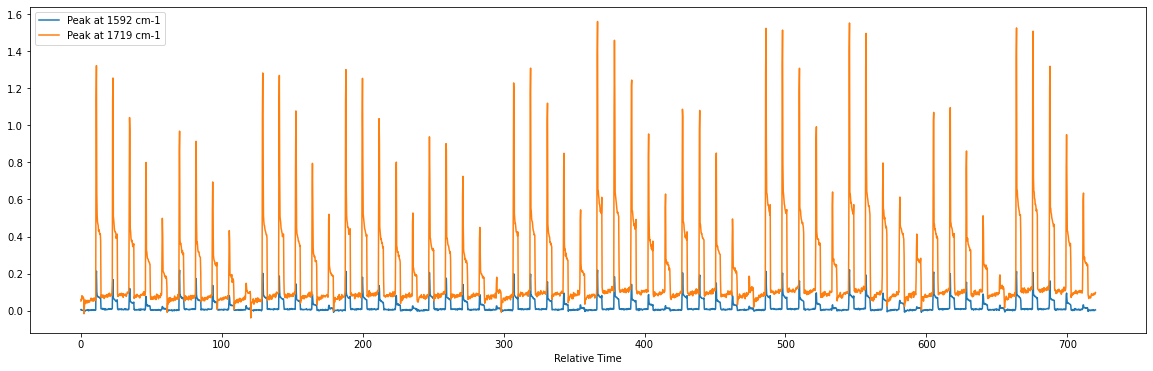

In [4]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [5]:
# List all the wavelengths observed
print([col for col in ir_data.columns if 'Peak' in col])

['Peak at 1592 cm-1', 'Peak at 1719 cm-1']


In [6]:
# Choose peak
peak_of_interest = 'Peak at 1592 cm-1'

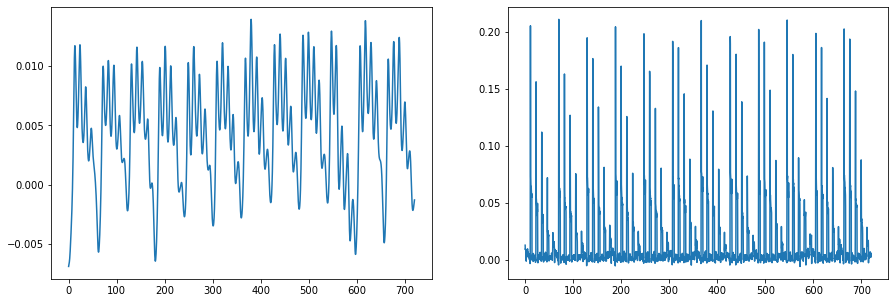

In [7]:
# Correct Baseline (needed if using area data)
correction = Data.baseline_correction(ir_data[peak_of_interest], peak_of_interest)
ir_data[peak_of_interest] = ir_data[peak_of_interest] - correction

# Plot it to see
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(ir_data['Relative Time'], correction)
ax2.plot(ir_data['Relative Time'], ir_data['Peak at 1592 cm-1'])

In [8]:
# Instantiate class
peaks = Peaks(ir_data)

# Auto find prominence and height to match number of conditions
prominence, no_reactions, points_per_reaction = peaks.auto_prom(peak_of_interest)
height = peaks.auto_height(peak_of_interest)
residence_time = peaks.auto_area(peak_of_interest, prominence, no_reactions, points_per_reaction)

print('There are', no_reactions, 'reactions with', points_per_reaction, 'points per reaction')
print('Prominence threshold =', np.round(prominence, 4))
print('Height threshold =', np.round(height, 4))
print('Residence time =', np.round(residence_time, 2))

There are 12 reactions with 5 points per reaction
Prominence threshold = 0.016
Height threshold = 1.0
Residence time = 2.73


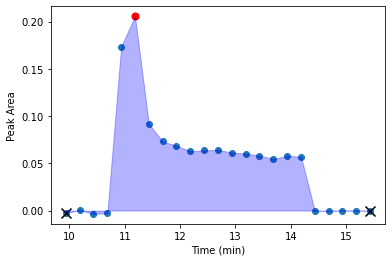

0


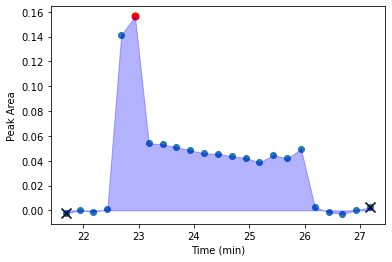

1


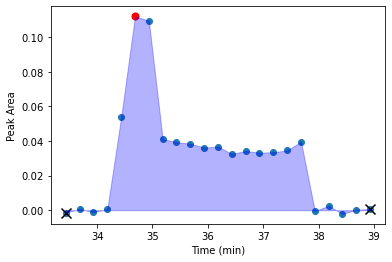

2


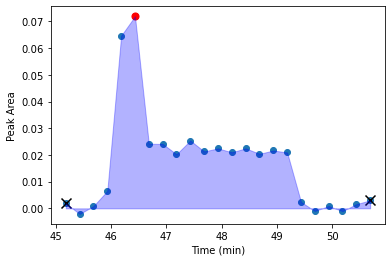

3


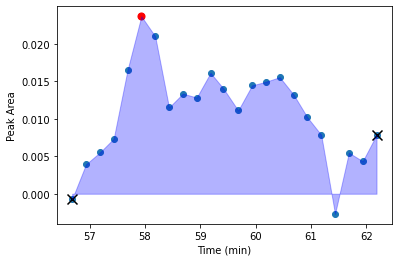

4


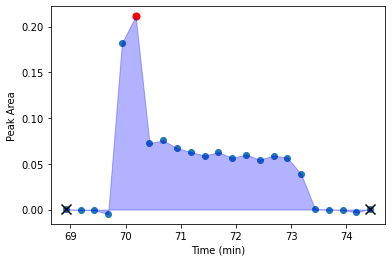

5


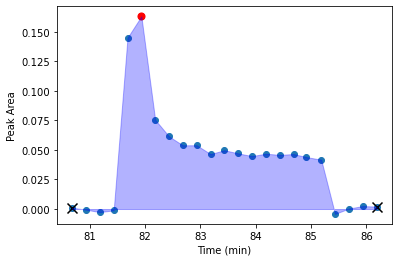

6


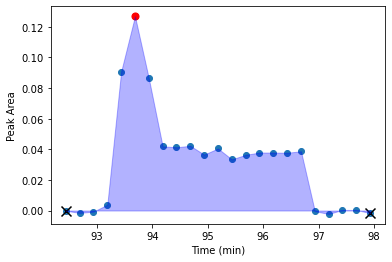

7


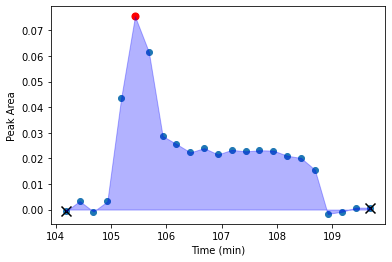

8


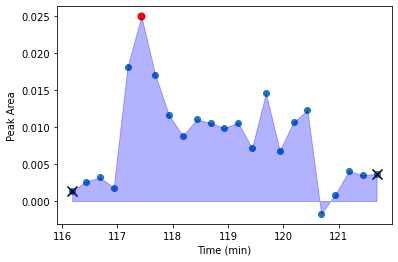

9


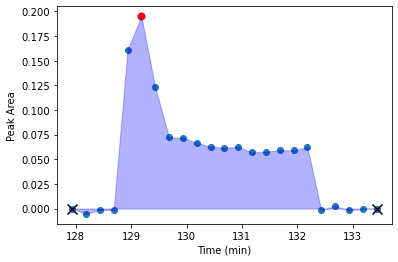

10


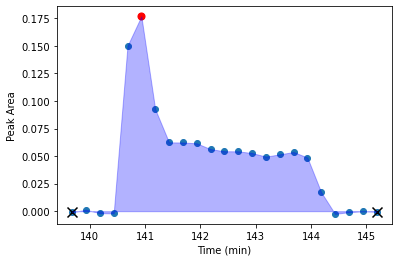

11


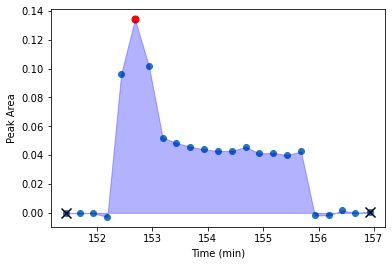

12


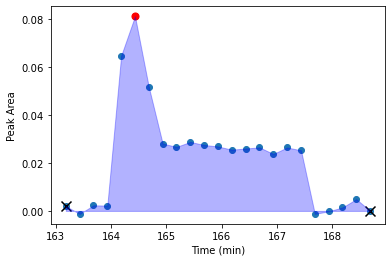

13


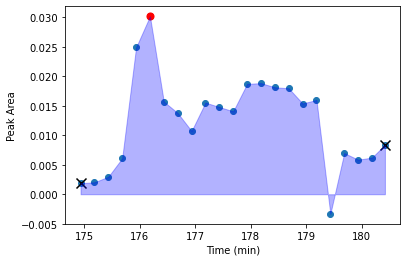

14


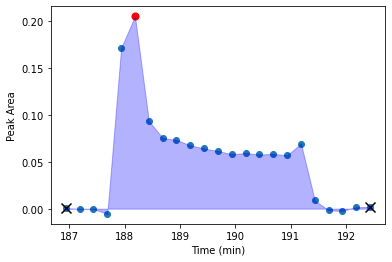

15


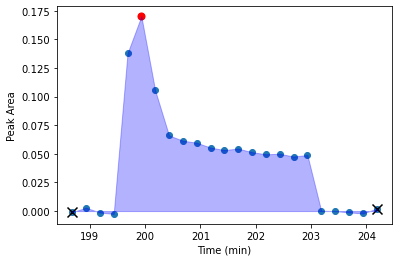

16


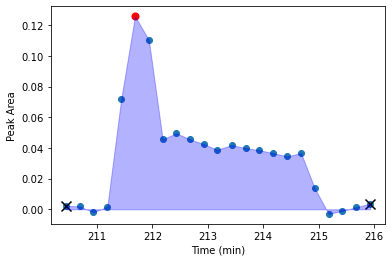

17


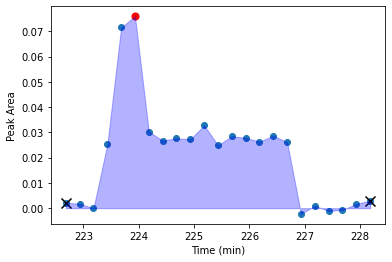

18


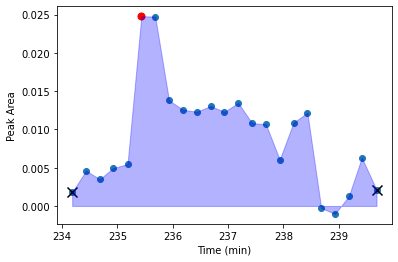

19


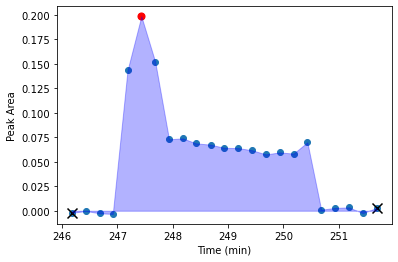

20


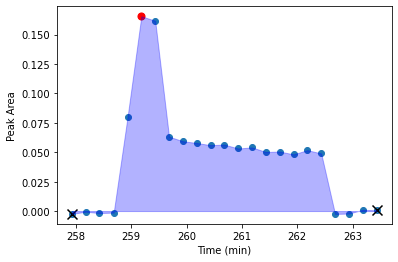

21


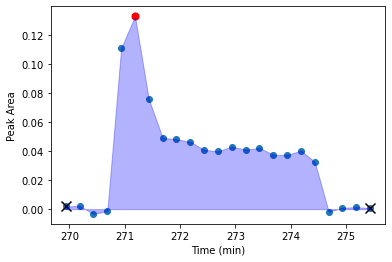

22


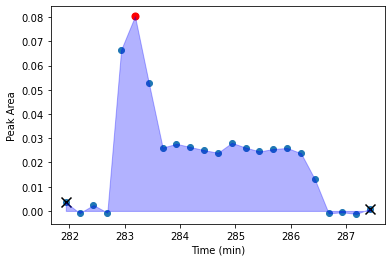

23


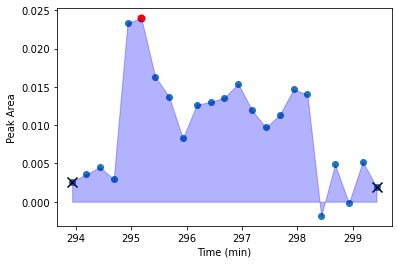

24


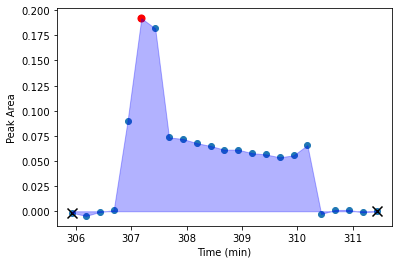

25


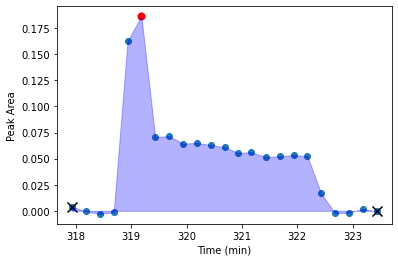

26


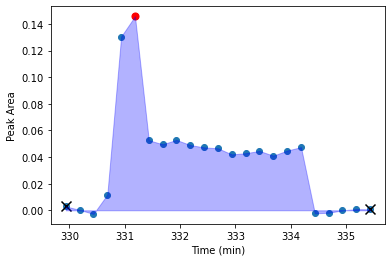

27


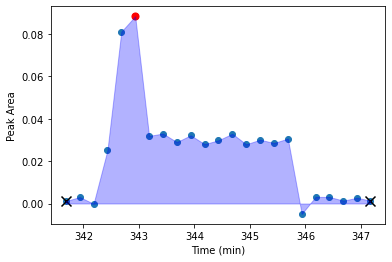

28


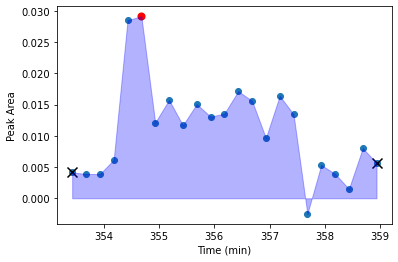

29


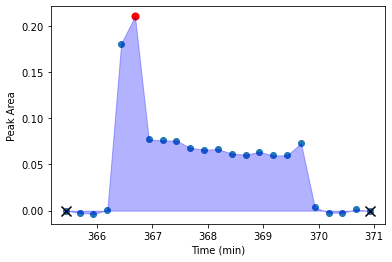

30


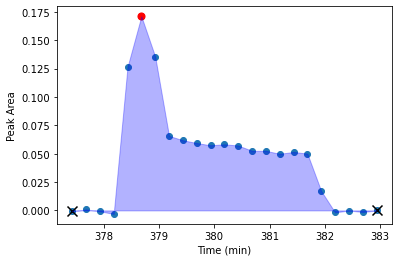

31


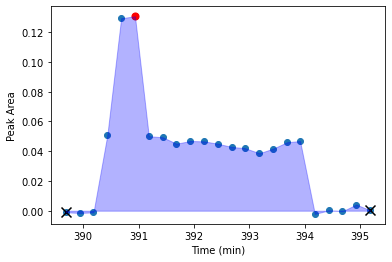

32


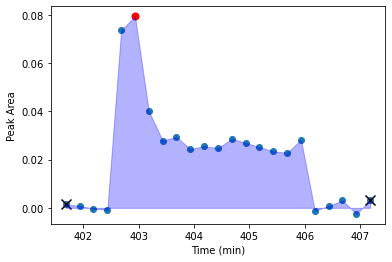

33


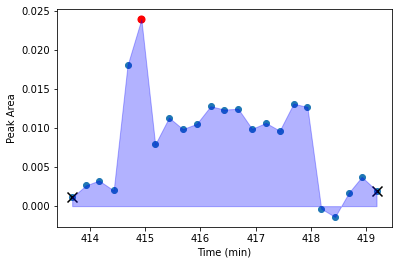

34


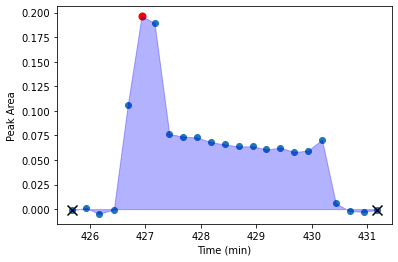

35


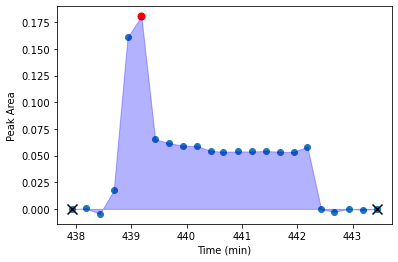

36


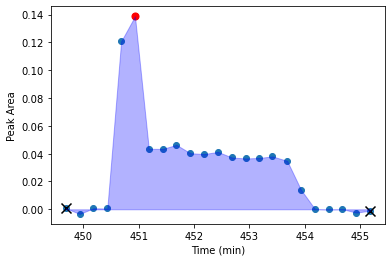

37


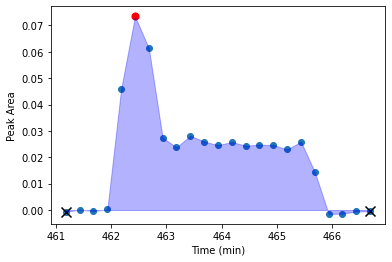

38


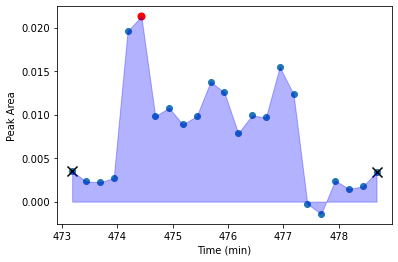

39


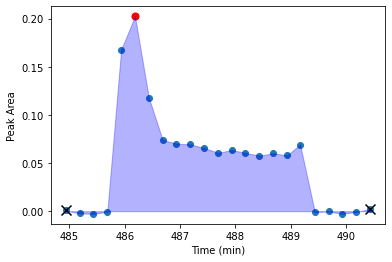

40


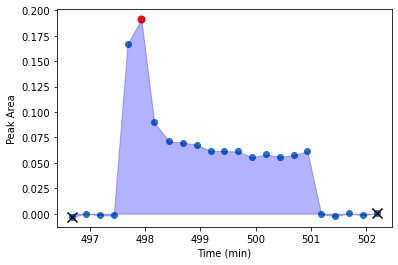

41


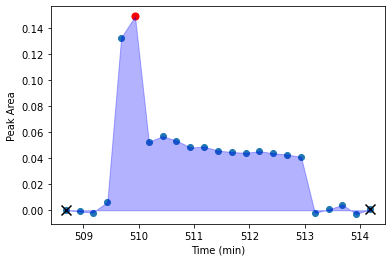

42


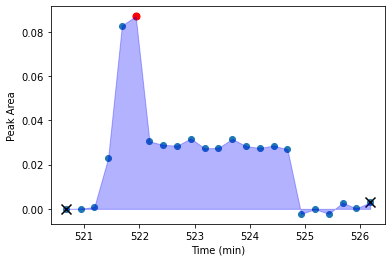

43


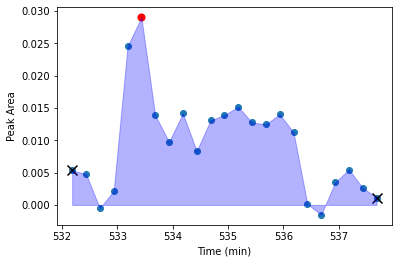

44


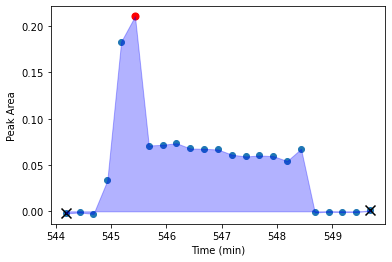

45


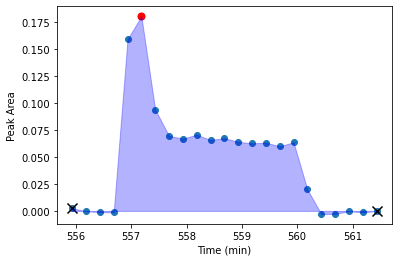

46


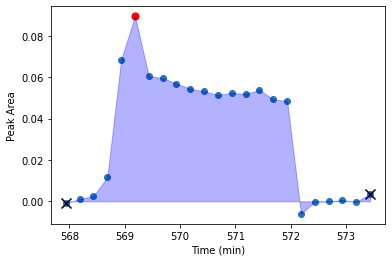

47


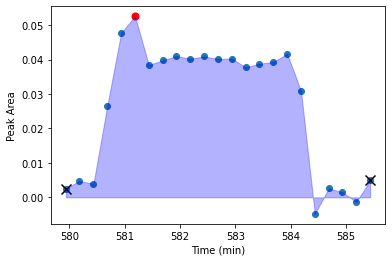

48


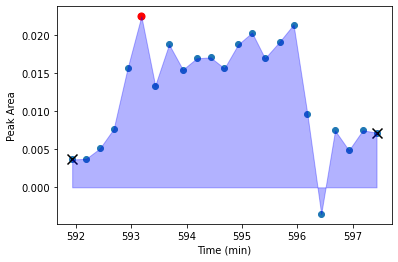

49


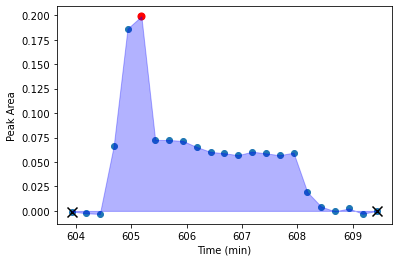

50


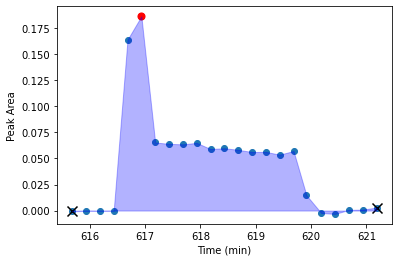

51


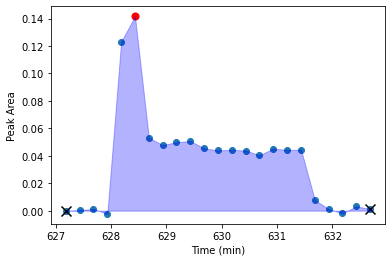

52


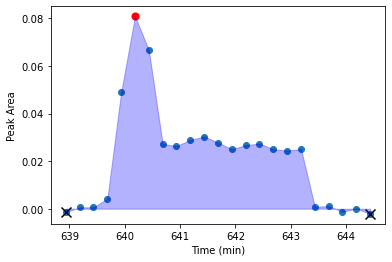

53


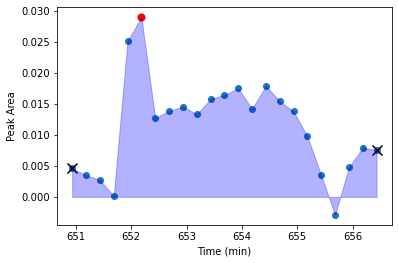

54


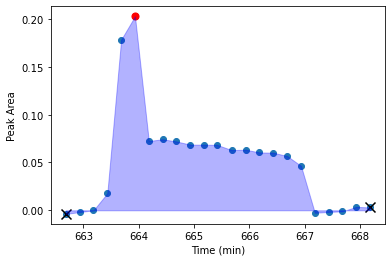

55


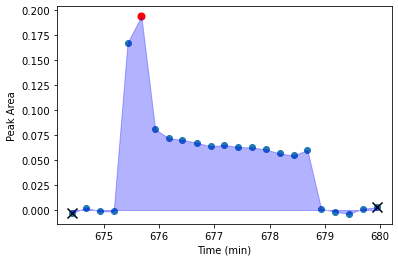

56


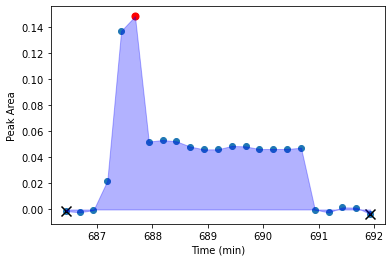

57


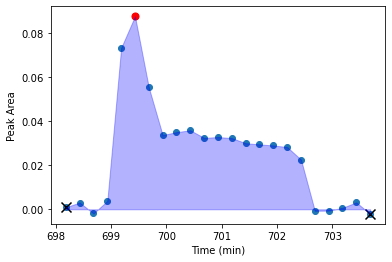

58


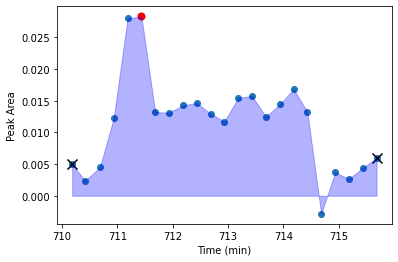

59


In [9]:
# Set some variables
time_adjust_before = 0
time_adjust_after = 3

# For loop to see all areas
for var in range(0, no_reactions * points_per_reaction):
    peaks.exp_area_sp(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after, var)
    print(var)

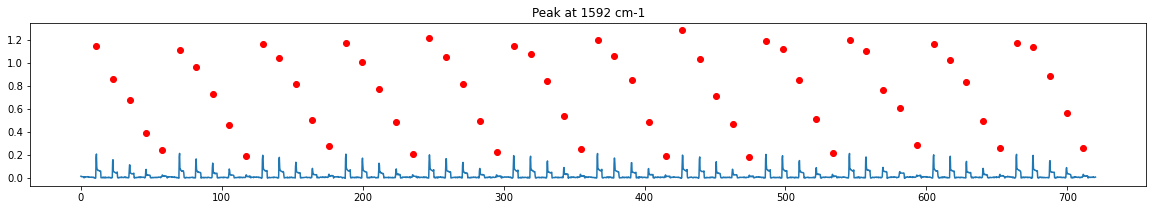

In [10]:
## PROMINENCE ALL WAVELENGTHS: Determine the peak prominences of every wavelength
#processed_ir_data = peaks.prominence_all(prominence)

## PROMINENCE: Determine the peak prominences of a single wavelength
#processed_ir_data = peaks.prominence(prominence, peak_of_interest)

## HEIGHT: # Determine the peak heights of a single wavelength
#processed_ir_data = peaks.height(height, peak_of_interest)

## EXP AREA: Determine the experimental areas of a single wavelength
processed_ir_data = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## FITTED AREA: Determine the fitted areas of a single wavelength
#processed_ir_data = peaks.fitted_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## Visualise which peaks have been picked - single peak
peaks.plot(processed_ir_data, peak_of_interest)

## Compare prominence, height, experimental area, and fitted area
#r2, compare = peaks.compare_no_height(prominence, residence_time, peak_of_interest, no_reactions, points_per_reaction, time_adjust_before, time_adjust_after)
# NOTE: Areas seem to give the best value when the starting point is exactly on the peak (no baseline before)

#processed_ir_data
#r2

### Smooth the data

#### Average t0s

In [11]:
processed_ir_data = peaks.t0_correction(processed_ir_data, no_reactions, points_per_reaction)

#### Apply linear smoothing

In [12]:
processed_ir_data = peaks.linear_correction(processed_ir_data, no_reactions, points_per_reaction)

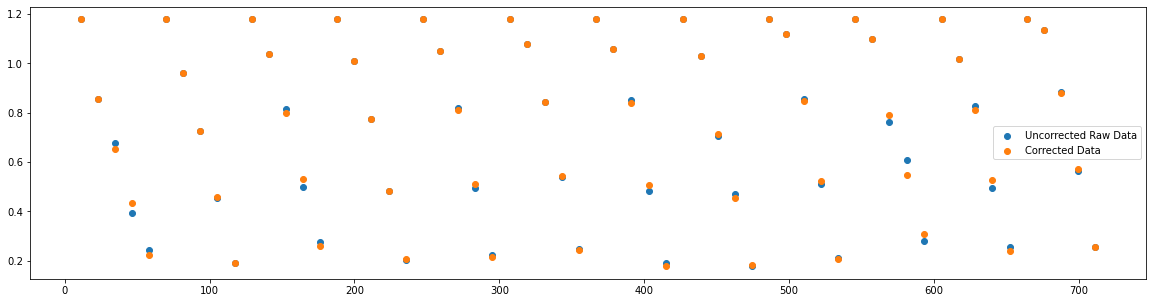

In [13]:
plt.figure(figsize=(20,5))
plt.scatter(processed_ir_data['Relative Time'], processed_ir_data['Raw Peak Property'], label = 'Uncorrected Raw Data')
plt.scatter(processed_ir_data['Relative Time'], processed_ir_data['Peak Property'], label = 'Corrected Data')
plt.legend()
plt.show()

# Read experimental conditions and add to dataframe

In [14]:
Conditions()
experimental_data = Conditions.read(processed_ir_data)
#experimental_data

Inputs seem good: IR Datapoints =  60 , Number of conditions =  60


### Create the SPKA profiles

In [15]:
spka = SPKA(experimental_data)

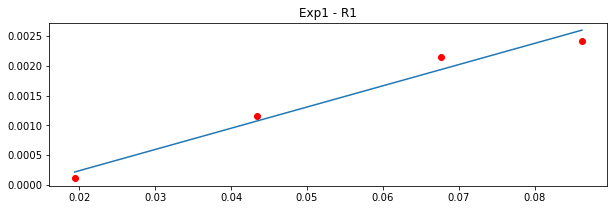

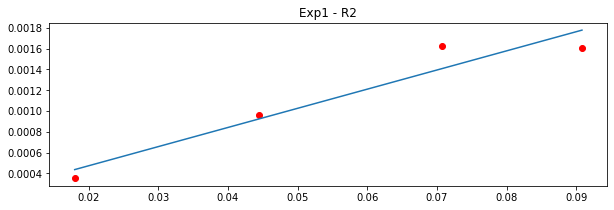

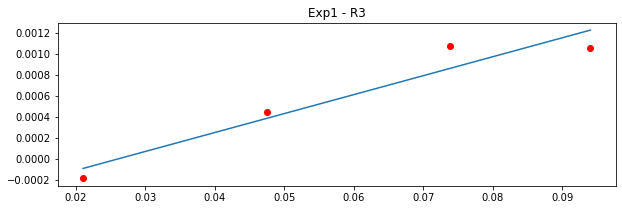

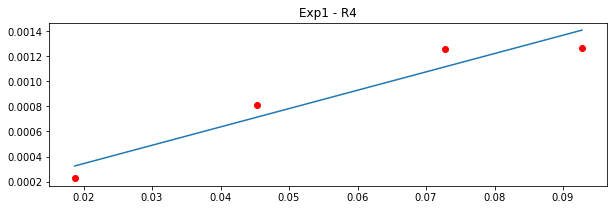

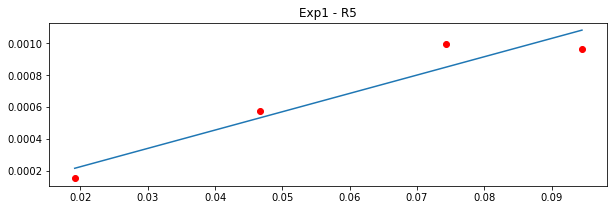

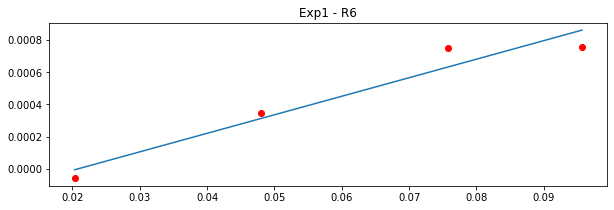

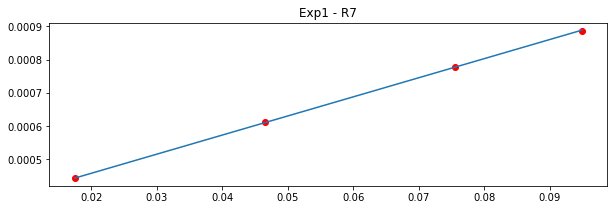

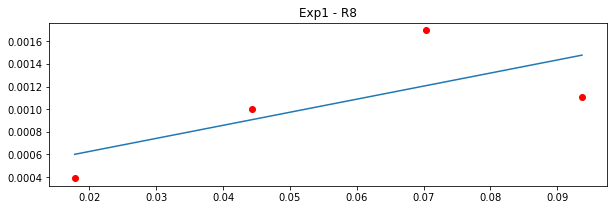

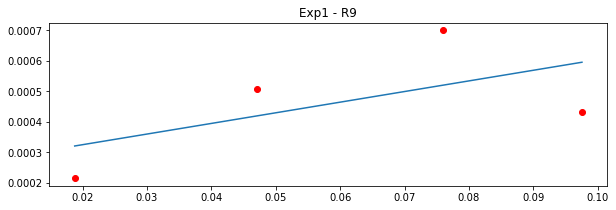

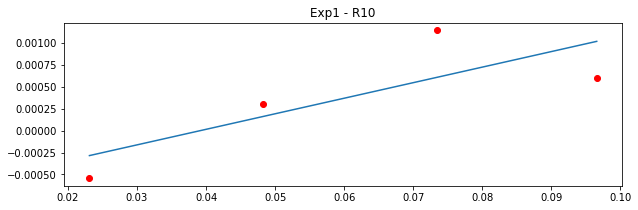

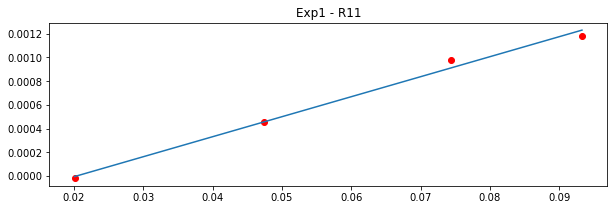

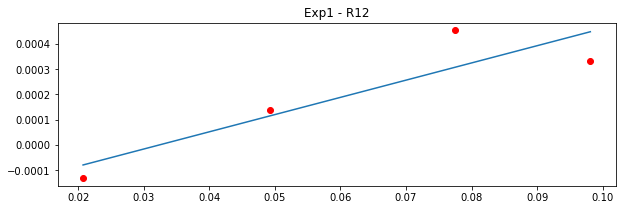

In [16]:
spka_data = spka.spka('[A]0')
#spka_data
spka.plot(spka_data)

## To Compare - must use Conditions.read(compare)
#r2 = spka.compare('[A]0')
#r2

### Perform RPKA

# New Code - Working Functions

Working on the assumption that three experiments per system, first is standard, second is change in B, third is change in catalyst

# def _init_

In [17]:
# I don't think this is needed...
# Find unique reaction numbers
#reaction_list = spka_data['Experiment'].unique()

In [18]:
# Create new dataframe from rpka_data
rpka_data = spka_data.drop(columns=['Interval Size',
                                   'tR (min)',
                                   'SPKA',
                                   'Relative Time',
                                   'Peak Property',
                                   'Method',
                                   'SPKA Conversion',
                                   'SPKA Ideal t0 Concentration',
                                   'Normalised IR Concentration',
                                   'Initial Conv',
                                   'Raw Peak Property'])

#rpka_data

In [19]:
# Determine parameters needed for RPKA
rpka_data['[Excess]'] = rpka_data['[B]0'] - rpka_data['[A]0']
rpka_data['[B]'] = rpka_data['[A]'] + rpka_data['[Excess]']
rpka_data['[C]'] = rpka_data['[C]0']
#rpka_data

In [20]:
# If 'reagents.xslx' exists, then rename reagents. Otherwise pass exception to user.

try:
    # Read reagents.xlsx to get reagent names
    reagent_names = pd.read_excel('reagents.xlsx', header = None, names = ['Abbreviation','Reagent Name'])

    # Need this as a dictionary
    reagent_names = dict(zip(reagent_names['Abbreviation'], reagent_names['Reagent Name']))
    
    # Map the keys and values
    rpka_data["A"] = rpka_data["A"].map(reagent_names)
    rpka_data["B"] = rpka_data["B"].map(reagent_names)
    rpka_data["C"] = rpka_data["C"].map(reagent_names)    
    
except:
    print("'reagents.xlsx' could not be found, reagents will remain unnamed")
    
rpka_data

,Experiment,A,B,C,[A]0,[B]0,[C]0,Rate,[A],[Excess],[B],[C]
0,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.0024161,0.0862282,0.05,0.136228,0.02
1,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.00215426,0.0677207,0.05,0.117721,0.02
2,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.00114793,0.0434568,0.05,0.0934568,0.02
3,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.000107025,0.01939,0.05,0.06939,0.02
4,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.00160914,0.0908279,0.00,0.0908279,0.02
5,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.00162098,0.0707604,0.00,0.0707604,0.02
6,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.000964874,0.0445002,0.00,0.0445002,0.02
7,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.000350799,0.0180004,0.00,0.0180004,0.02
8,Exp1 - R3,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.01,0.00105044,0.0940125,0.05,0.144012,0.01
9,Exp1 - R3,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.01,0.00107052,0.073898,0.05,0.123898,0.01


In [21]:
# Currently, we run three reactions per system
reactions_per_system = 3

# t0 data is no longer included
points_per_system = points_per_reaction -1

# Determine the number of systems in this run
number_of_systems = len(rpka_data) / (points_per_system * reactions_per_system)

# def choose_system(x):

In [24]:
def choose_system(system_number):
    """
    For internal use.
    
    Returns a dataframe of a single system. Starts at 0!
    Works on the assumption that there are three reactions per system studied.
    
    Parameters
    ----------
    system_number: The system to return, in numerical order, from rpka_data
    
    Returns
    -------
    system: Dataframe of a single system
    """
    
    # Create a list of the rows in which new systems start, to be use in iloc based slicing
    starting_point = [var for var in range(0,len(rpka_data),(points_per_system) * reactions_per_system)]
    
    # Which system are we finding? Determined by function parameter.
    var = starting_point[system_number]
    
    # Create dataframe of individual system, all relative to the starting point
    system = rpka_data.iloc[var : var + points_per_system * reactions_per_system, :].reset_index(drop = True)
        
    return system

In [25]:
choose_system(2)

,Experiment,A,B,C,[A]0,[B]0,[C]0,Rate,[A],[Excess],[B],[C]
0,Exp1 - R7,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.15,0.02,0.000887362,0.094942,0.05,0.144942,0.02
1,Exp1 - R7,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.15,0.02,0.000779372,0.0755576,0.05,0.125558,0.02
2,Exp1 - R7,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.15,0.02,0.000611034,0.0465171,0.05,0.0965171,0.02
3,Exp1 - R7,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.15,0.02,0.000442695,0.0174766,0.05,0.0674766,0.02
4,Exp1 - R8,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.10,0.02,0.00110477,0.0937028,0.00,0.0937028,0.02
5,Exp1 - R8,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.10,0.02,0.00169822,0.0703202,0.00,0.0703202,0.02
6,Exp1 - R8,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.10,0.02,0.00100142,0.0442919,0.00,0.0442919,0.02
7,Exp1 - R8,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.10,0.02,0.000388739,0.0177842,0.00,0.0177842,0.02
8,Exp1 - R9,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.15,0.01,0.000431695,0.0975393,0.05,0.147539,0.01
9,Exp1 - R9,2-Chlorobenzaldehyde,Acetone,Proline-OTBS,0.1,0.15,0.01,0.000699846,0.0760109,0.05,0.126011,0.01


# Functions to minimise

In [26]:
def sum_residuals_b(x):
    
    """
    Returns the sum of the residauls to find the order in B (b). To be used in the minimiser
    """

    # Residuals for finding b (order in B), y-axis is Rate/[B]b
    residuals = ((standard_rate.to_numpy() / (standard_conc_B.to_numpy() ** x)) 
                 - (diff_B_rate.to_numpy() / (diff_B_conc_B.to_numpy() ** x)))

    # Sum the residuals ** 2
    sum_residuals = np.sum(residuals ** 2)
    
    return sum_residuals

In [27]:
def straight_line_a(x):
    
    """
    Returns the summed r2 of two kinetic profiles to find the order in A (a)
    For now, discounts the first reaction point as it is often wonky.
    """
    
    # This will need to change
    b = order_in_B
    
    # Find the r2 for the standard reaction
    rxn_standard_r2 = np.corrcoef((standard_conc_A ** x).astype(float)[1:],
                                  (standard_rate / standard_conc_B ** b).astype(float)[1:], 1)[0,1] # TO UPDATE FOR b!

    # Find the r2 for the change in B reaction
    rxn_diff_B_r2 = np.corrcoef((diff_B_conc_A ** x).astype(float)[1:],
                                  (diff_B_rate / diff_B_conc_B ** b).astype(float)[1:], 1)[0,1] # TO UPDATE FOR b!
    
    r2_to_min = -(rxn_standard_r2 + rxn_diff_B_r2)
    
    return r2_to_min

In [229]:
def sum_residuals_c(x):
    
    """
    Returns the sum of the residauls to find the order in C (c). To be used by the minimiser.
    """

    # Residuals for finding c (order in C), y-axis is Rate/[C]c
    residuals = ((standard_rate.to_numpy() / (standard_conc_C.to_numpy() ** x)) 
                 - (diff_C_rate.to_numpy() / (diff_C_conc_C.to_numpy() ** x)))

    # Sum the residuals ** 2
    sum_residuals = np.sum(residuals ** 2)
    
    return sum_residuals

# def rpka.diff_excess()

In [233]:
def diff_excess(min_meth = 'BFGS', bnds =((-1,1),)):
    
    """
    Perform a different excess analysis.

    Reactions MUST be performed in this order:
    Standard
    Different [B]
    Different [C] - where C is catalyst

    Parameters
    ----------
    method: Minimiser method: BFGS (default), CG, TNC, trust-constr
    bnds: bounds for minimiser, default (-1,1)
    
    Returns
    -------
    rpka_data: original dataframe with columnns for each reagent order

    """
    
    # Need a for loop to work through each system
    for var in range(0, number_of_systems.astype(int), 1):
        
        # Choose the system
        tmp = choose_system(var)

        # Create some variables to pass up to funtions for minimiser
        # Standard Reaction is run first
        standard_rate = tmp['Rate'].iloc[0 : points_per_system]
        standard_conc_A = tmp['[A]'].iloc[0 : points_per_system]
        standard_conc_B = tmp['[B]'].iloc[0 : points_per_system]
        standard_conc_C = tmp['[C]'].iloc[0 : points_per_system]

        # Reaction with different [B] will always be run second
        diff_B_rate = tmp['Rate'].iloc[points_per_system : 2 * points_per_system]
        diff_B_conc_A = tmp['[A]'].iloc[points_per_system : 2 * points_per_system]
        diff_B_conc_B = tmp['[B]'].iloc[points_per_system : 2 * points_per_system]

        # Reaction with different [C] will always be run third
        diff_C_rate = tmp['Rate'].iloc[2 * points_per_system : 3 * points_per_system]
        diff_C_conc_A = tmp['[A]'].iloc[points_per_system : 2 * points_per_system]
        diff_C_conc_C = tmp['[C]'].iloc[2 * points_per_system : 3 * points_per_system]

        # Determine order in B. Must be first as order_in_B is required to find order in A
        order_in_B = minimize(sum_residuals_b, 1, method = min_meth, bounds=bnds).x

        # Determine order in A
        order_in_A = minimize(straight_line_a, 1, method = min_meth, bounds=bnds).x

        # Determing order in C
        order_in_C = minimize(sum_residuals_c, 1, method = min_meth, bounds=bnds).x

        # Create a series of each order of length tmp to append in loop
        a = pd.Series(np.round(order_in_A, 2)).repeat(len(tmp))
        b = pd.Series(np.round(order_in_B, 2)).repeat(len(tmp))
        c = pd.Series(np.round(order_in_C, 2)).repeat(len(tmp))

        df_a.append(a)
        df_b.append(b)
        df_c.append(c)
    
    # Orders
    rpka_data['Order in A'] = pd.concat(df_a, ignore_index = True)
    rpka_data['Order in B'] = pd.concat(df_b, ignore_index = True)
    rpka_data['Order in C'] = pd.concat(df_c, ignore_index = True)
    
    # Data for plotting in python or excel
    rpka_data['[A]a'] = rpka_data['[A]'].astype(float) ** rpka_data['Order in A']
    rpka_data['[B]b'] = rpka_data['[B]'].astype(float) ** rpka_data['Order in B']
    rpka_data['Rate/[B]b'] = rpka_data['Rate'].astype(float) / rpka_data['[B]b']
    rpka_data['Rate/[C]c'] = rpka_data['Rate'].astype(float) / rpka_data['[C]'] ** rpka_data['Order in C'].astype(float)
    
    return rpka_data

In [234]:
final_rpka_data = diff_excess()
final_rpka_data

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:533: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


,Experiment,A,B,C,[A]0,[B]0,[C]0,Rate,[A],[Excess],[B],[C],Order in A,Order in B,Order in C,[A]a,[B]b,Rate/[A]a,Rate/[C]c,Rate/[B]b
0,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.0024161,0.0862282,0.05,0.136228,0.02,0.77,0.29,1.0,0.151513,0.560967,0.015946,0.120805,0.004307
1,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.00215426,0.0677207,0.05,0.117721,0.02,0.77,0.29,1.0,0.125793,0.537709,0.017125,0.107713,0.004006
2,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.00114793,0.0434568,0.05,0.0934568,0.02,0.77,0.29,1.0,0.089393,0.502895,0.012841,0.057397,0.002283
3,Exp1 - R1,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.02,0.000107025,0.01939,0.05,0.06939,0.02,0.77,0.29,1.0,0.048021,0.461292,0.002229,0.005351,0.000232
4,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.00160914,0.0908279,0.00,0.0908279,0.02,0.77,0.29,1.0,0.157699,0.498751,0.010204,0.080457,0.003226
5,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.00162098,0.0707604,0.00,0.0707604,0.02,0.77,0.29,1.0,0.130118,0.463916,0.012458,0.081049,0.003494
6,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.000964874,0.0445002,0.00,0.0445002,0.02,0.77,0.29,1.0,0.091041,0.405532,0.010598,0.048244,0.002379
7,Exp1 - R2,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.10,0.02,0.000350799,0.0180004,0.00,0.0180004,0.02,0.77,0.29,1.0,0.045349,0.311912,0.007736,0.017540,0.001125
8,Exp1 - R3,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.01,0.00105044,0.0940125,0.05,0.144012,0.01,0.77,0.29,1.0,0.161940,0.570080,0.006487,0.105044,0.001843
9,Exp1 - R3,2-Chlorobenzaldehyde,Acetone,Proline,0.1,0.15,0.01,0.00107052,0.073898,0.05,0.123898,0.01,0.77,0.29,1.0,0.134539,0.545744,0.007957,0.107052,0.001962


# def rpka.check_results()

Takes what's been calculated and plots everything to visually check

In [235]:
def check_results(final_rpka_data):
    
    """
    Shows the RPKA profiles for the auto-found orders as a visual check.

    Parameters
    ----------
    final_rpka_data: Needs the output dataframe from rpka.diff_excess()
    
    Returns
    -------
    Plots of Rate/[B]b vs [A]a and Rate/[C]c vs [A] for each system

    """  
    
    # Create subplots
    fig, ax = plt.subplots(number_of_systems.astype(int), 2, figsize = (15,15))
    fig.tight_layout(w_pad = 5, h_pad = 5) # Makes spacing better

    # Set the row, will be up to max number of systems
    for var_row in range(0, number_of_systems.astype(int), 1):

        # Cannot use choose_system as needs rpka_data dataframe as output from diff_excess()
        # Create a list of the rows in which new systems start, to be use in iloc based slicing
        starting_point = [var for var in range(0,len(final_rpka_data),(points_per_system) * reactions_per_system)]

        # Which system are we finding? Determined by function parameter.
        var = starting_point[var_row]

        # Create dataframe of individual system, all relative to the starting point
        tmp = final_rpka_data.iloc[var : var + points_per_system * reactions_per_system, :].reset_index(drop = True)

        # Define what to plot
        # Standard reaction - the first of the three systems
        rxn_standard_Aa = tmp['[A]a'].iloc[0 : points_per_system]
        rxn_standard_RateBb = tmp['Rate/[B]b'].iloc[0 : points_per_system]

        rxn_standard_A = tmp['[A]'].iloc[0 : points_per_system]
        rxn_standard_RateCc = tmp['Rate/[C]c'].iloc[0 : points_per_system]

        # Change in [B] - the second of the three systems
        rxn_diff_B_Aa = tmp['[A]a'].iloc[points_per_system : 2 * points_per_system]
        rxn_diff_B_RateBb = tmp['Rate/[B]b'].iloc[points_per_system : 2 * points_per_system]

        # Change in [C] - the third of the three systems
        rxn_diff_C_A = tmp['[A]'].iloc[2 * points_per_system : 3 * points_per_system]
        rxn_diff_C_RateCc = tmp['Rate/[C]c'].iloc[2 * points_per_system : 3 * points_per_system]

        # Plot order in A and B - first column
        ax[var_row, 0].scatter(rxn_standard_Aa, rxn_standard_RateBb)
        ax[var_row, 0].scatter(rxn_diff_B_Aa, rxn_diff_B_RateBb)

        # Plot order in C - second column
        ax[var_row, 1].scatter(rxn_standard_A, rxn_standard_RateCc)
        ax[var_row, 1].scatter(rxn_diff_C_A, rxn_diff_C_RateCc)

        # Set titles
        ax[var_row, 0].set_title(str(tmp['A'][0]) + ' ^ ' + str(tmp['Order in A'][0]) + ' : ' +
                                 str(tmp['B'][0]) + ' ^ ' + str(tmp['Order in B'][0]))
        ax[var_row, 1].set_title(str(tmp['C'][0]) + ' ^ ' + str(tmp['Order in C'][0]))

        # Set labels
        ax[var_row, 0].set_ylabel('Rate/[B]b')
        ax[var_row, 0].set_xlabel('[A]a')

        ax[var_row, 1].set_ylabel('Rate/[C]c')
        ax[var_row, 1].set_xlabel('[A]')

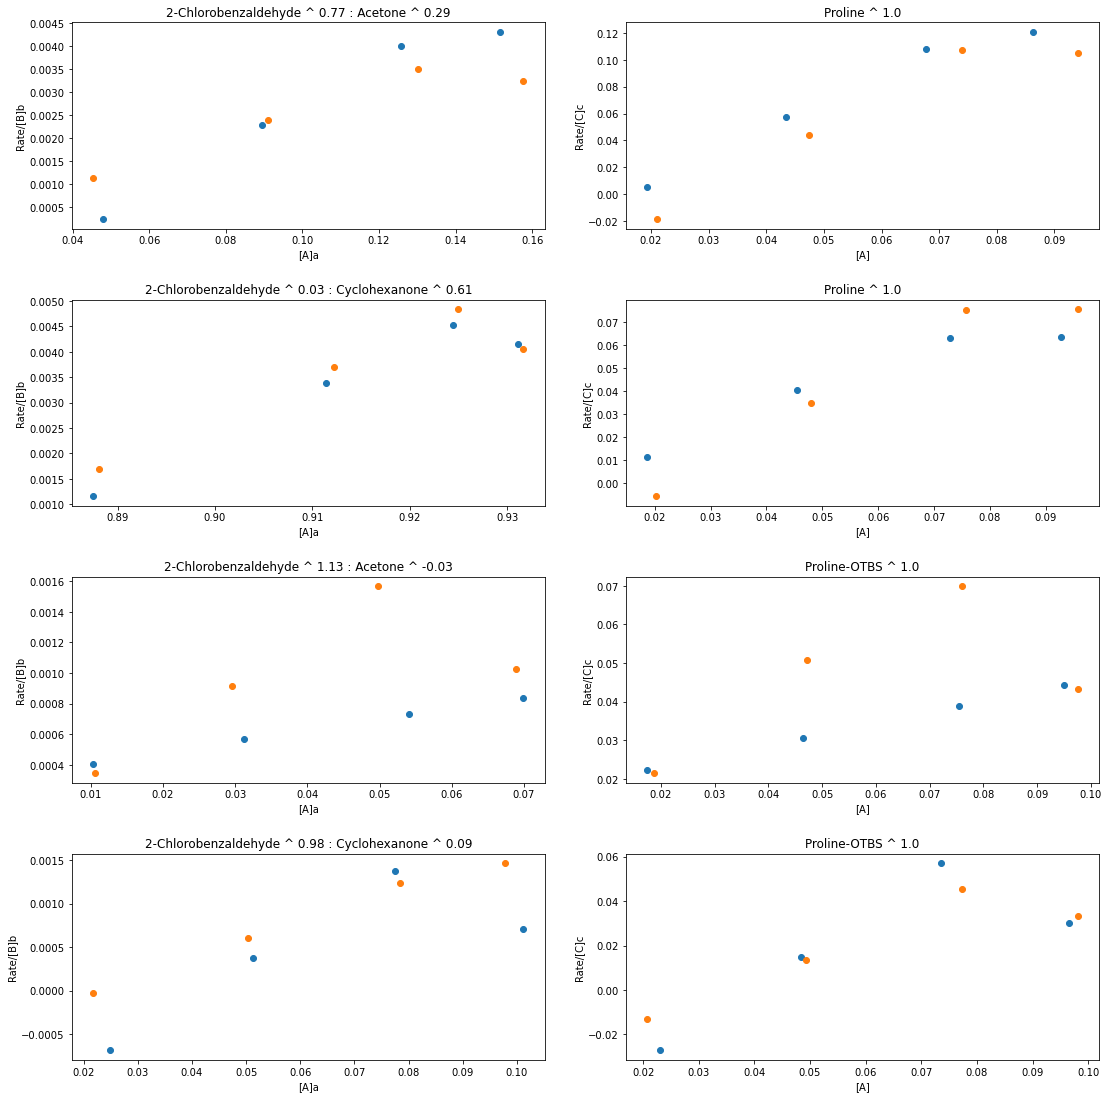

In [236]:
check_results(final_rpka_data)

# def rpka.manual()

In [213]:
def manual(system_number, a, b, c):
    
    """
    Perform a manual different excess analysis for a single system.

    Parameters
    ----------
    system_number: Which system, starting at 0
    a: Order in A - Looking for linearity
    b: Order in B - Looking for overlay
    c: Order in C - Looking for overlay
    
    Returns
    -------
    Plots of Rate/[B]b vs [A]a and Rate/[C]c vs [A]

    """  
    tmp = choose_system(system_number)
    
    # To plot
    rxn_standard_Aa = tmp['[A]'].iloc[0 : points_per_system] ** a
    rxn_standard_RateBb = tmp['Rate'].iloc[0 : points_per_system] / tmp['[B]'].iloc[0 : points_per_system] ** b

    rxn_standard_A = tmp['[A]'].iloc[0 : points_per_system]
    rxn_standard_RateCc = tmp['Rate'].iloc[0 : points_per_system] / tmp['[C]'].iloc[0 : points_per_system] ** c

    # Change in [B] - the second of the three systems
    rxn_diff_B_Aa = tmp['[A]'].iloc[points_per_system : 2 * points_per_system] ** a
    rxn_diff_B_RateBb = tmp['Rate'].iloc[points_per_system : 2 * points_per_system] / tmp['[B]'].iloc[points_per_system : 2 * points_per_system] ** b

    # Change in [C] - the third of the three systems
    rxn_diff_C_A = tmp['[A]'].iloc[2 * points_per_system : 3 * points_per_system]
    rxn_diff_C_RateCc = tmp['Rate'].iloc[2 * points_per_system : 3 * points_per_system] / tmp['[C]'].iloc[2 * points_per_system : 3 * points_per_system] ** c

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    # Plot order in A and B - first column
    ax[0].scatter(rxn_standard_Aa, rxn_standard_RateBb)
    ax[0].scatter(rxn_diff_B_Aa, rxn_diff_B_RateBb)

    # Plot order in C - second column
    ax[1].scatter(rxn_standard_A, rxn_standard_RateCc)
    ax[1].scatter(rxn_diff_C_A, rxn_diff_C_RateCc)

    # Set titles
    ax[0].set_title(str(tmp['A'][0]) + ' ^ ' + str(a) + ' : ' + str(tmp['B'][0]) + ' ^ ' + str(b))
    ax[1].set_title(str(tmp['C'][0]) + ' ^ ' + str(c))

    # Set labels
    ax[0].set_ylabel('Rate/[B]b')
    ax[0].set_xlabel('[A]a')

    ax[1].set_ylabel('Rate/[C]c')
    ax[1].set_xlabel('[A]')

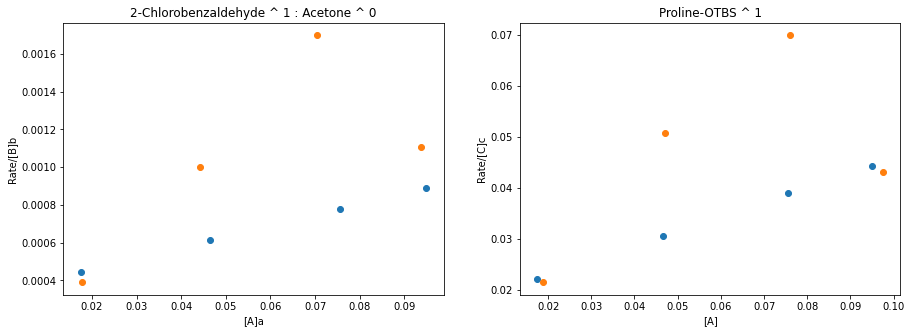

In [221]:
manual(2,1,0,1)

# def rpka.diff_excess_grid()

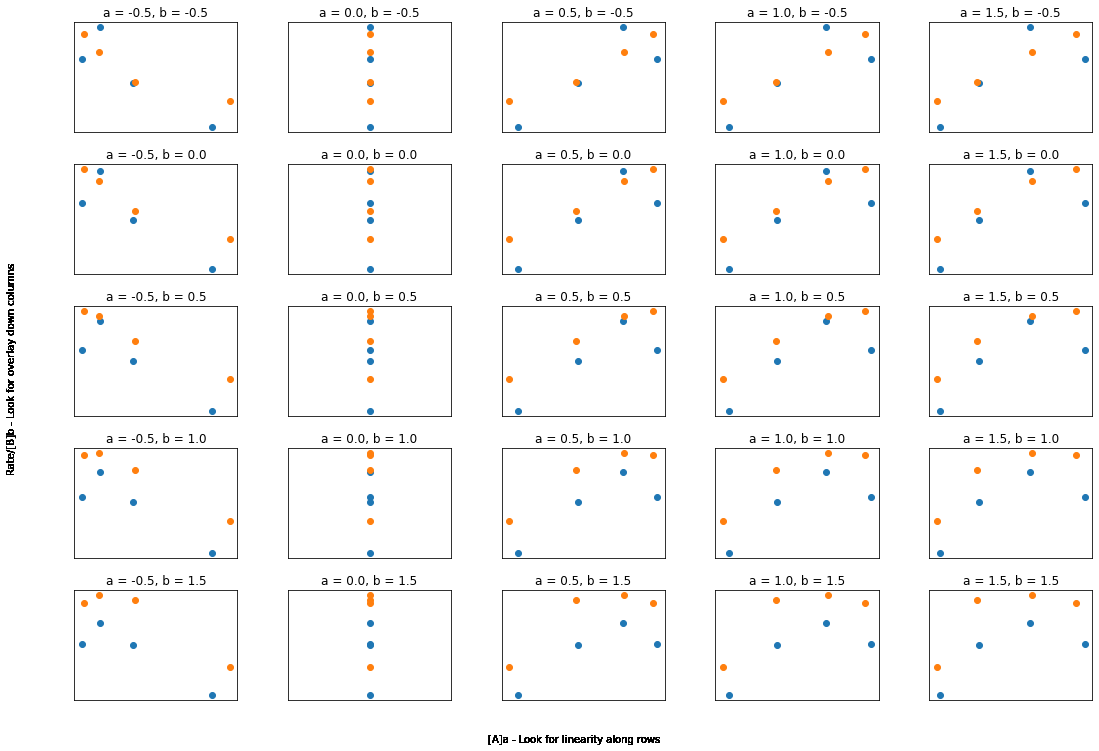

In [31]:
lower_order = -.5
upper_order = 1.5
no_steps = 5

# Create the range of orders to look over
rpka_range = np.linspace(lower_order, upper_order, no_steps)

# Create subplots
fig, ax = plt.subplots(no_steps, no_steps, figsize = (15,10))
fig.tight_layout(w_pad=1) # Makes spacing better
#fig.subplots_adjust(hspace=0.8) # Also makes spacing better

# Change a vertically and b horizontally, go along rows first
# Set the row
for var1 in range(0, no_steps):

    # Work along row - this is b
    var_hor = rpka_range[var1]
    
    # Work down column
    for var2 in range(0, no_steps):
        
        # Work along the chosen range - this is a
        var_vert = rpka_range[var2]
        
        # Define what to plot
        # Standard reaction - the first of the three systems
        rxn_standard_x = tmp['[A]'].iloc[0 : points_per_system] ** var_vert
        rxn_standard_y = tmp['Rate'].iloc[0 : points_per_system] / (tmp['[B]'].iloc[0 : points_per_system] ** var_hor)

        # Change in [B] - the second of the three systems
        rxn_diff_B_x = tmp['[A]'].iloc[points_per_system : 2 * points_per_system] ** var_vert
        rxn_diff_B_y = tmp['Rate'].iloc[points_per_system : 2 * points_per_system] / (tmp['[B]'].iloc[points_per_system : 2 * points_per_system] ** var_hor)
    
        # Plot it all
        ax[var1, var2].scatter(rxn_standard_x, rxn_standard_y)
        ax[var1, var2].scatter(rxn_diff_B_x, rxn_diff_B_y)
        
        # Set title containg orders
        ax[var1, var2].set_title('a = ' + str(np.round(var_vert,2)) + ', b = ' + str(np.round(var_hor,2)))
        
        # Remove the numbers on the axes
        ax[var1, var2].set_xticks([])
        ax[var1, var2].set_yticks([])
        
        # x and y-axis labels: either individual or common
        #ax[var1, var2].set_ylabel('Rate/[B]b')
        #ax[var1, var2].set_xlabel('[A]a')
        fig.text(0.5, -0.02, '[A]a - Look for linearity along rows', ha='center')
        fig.text(-0.025, 0.5, 'Rate/[B]b - Look for overlay down columns', va='center', rotation='vertical')        

# def rpka.diff_excess_best_fit()

Rather than using the raw data, use the best fit line, np.linspace up to ten or so - this might be best as an SPKA function to pass to rpka

# Code unlikely to use but don't want to delete

Determine order in B using a list of values, then taking the minimum

In [ ]:
# Create a dictionary of residuals over a range of orders
order_upper_bound = 1
order_lower_bound = -1
order_in_b_range = {var: sum_residuals_b(var) for var in np.linspace(order_lower_bound, order_upper_bound, 21)}

# Find the minimum sum_residual (value) and return the order (key)
order_in_b = min(order_in_b_range, key=order_in_b_range.get)
order_in_b

Visualise different orders in B

In [ ]:
# Plot to see
for var in np.linspace(order_lower_bound, order_upper_bound, 11):
   
    # Using old code to save time so need to define this
    b = var
    a = 1
    
    # Standard reaction - the first of the three systems
    rxn_standard_x = tmp['[A]'].iloc[0 : points_per_system] ** a
    rxn_standard_y = tmp['Rate'].iloc[0 : points_per_system] / (tmp['[B]'].iloc[0 : points_per_system] ** b)

    # Change in [B] - the second of the three systems
    rxn_diff_B_x = tmp['[A]'].iloc[points_per_system : 2 * points_per_system] ** a
    rxn_diff_B_y = tmp['Rate'].iloc[points_per_system : 2 * points_per_system] / (tmp['[B]'].iloc[points_per_system : 2 * points_per_system] ** b)
    
    plt.scatter(rxn_standard_x, rxn_standard_y)
    plt.scatter(rxn_diff_B_x, rxn_diff_B_y)
    
    print(var)
    
    plt.show()

In [ ]:
rpka = RPKA(spka_data)

In [ ]:
rpka_data = rpka.diff_excess()
rpka_data

In [ ]:
# Set up excelwriter
writer = pd.ExcelWriter(ir_data['Exp No'][0] + ' - ' +   # Adds experiment title - name of txt file
                        peak_of_interest[8:12] + ' - ' + # Adds the peak
                        processed_ir_data['Method'][0] + # Adds the methods used (prominence, area, etc)
                        '.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
#rpka_data.to_excel(writer, sheet_name='RPKA Data', startrow=0 , startcol=0, index=False)
spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
#conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False)

# Save
#writer.save()

# This won't work if the excel file is open